In [1]:
#!/usr/local/bin/python3

import os
import sys
from time import time
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import roc_curve, auc, log_loss
from scipy.stats import randint as sp_randint
from scipy import interp
#from drivendata_validator import DrivenDataValidator
import itertools
from tpot import TPOTClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# data directory
DATA_DIR = os.path.join('..', 'data')

C:\Users\Shaul\Anaconda2\envs\py37\lib\site-packages\sklearn\utils\__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence
C:\Users\Shaul\Anaconda2\envs\py37\lib\site-packages\deap\tools\_hypervolume\pyhv.py:33: ImportWarning: Falling back to the python version of hypervolume module. Expect this to be very slow.
  "module. Expect this to be very slow.", ImportWarning)
C:\Users\Shaul\Anaconda2\envs\py37\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
C:\Users\Shaul\Anaconda2\envs\py37\lib\importlib\_bootstrap_external.py:434: ImportWarning: Not importing directory C:\Users\Shaul\Anaconda2\envs\py37\lib\site-packages\mpl_toolkits: missing __init__
  _warnings.warn(msg.format(portions[0]), ImportWarning)
C:\Users\Shaul\Anaconda2\envs\p

In [2]:
## Make Submission DataFrame
def make_country_sub(preds, test_feat, country):
    # make sure we code the country correctly
    country_codes = ['A', 'B', 'C']
    
    # get just the poor probabilities
    country_sub = pd.DataFrame(data=preds[:, 1],  # proba p=1
                               columns=['poor'], 
                               index=test_feat.index)

    
    # add the country code for joining later
    country_sub["country"] = country
    return country_sub[["country", "poor"]]

# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

##### Household-level survey data: 
This is obfuscated data from surveys conducted by The World Bank, focusing on household-level statistics. The data come from three different countries, and are separated into different files for convenience.

##### Individual-level survey data: 
This is obfuscated data from related surveys conducted by The World Bank, only these focus on individual-level statistics. The set of interviewees and countries involved are the same as the household data, as indicated by shared id indices, but this data includes detailed (obfuscated) information about household members.

##### Submission format:
This gives us the filenames and columns of our submission prediction, filled with all 0.5 as a baseline.

In [3]:
## define data paths
data_paths = {'train_x': os.path.join(DATA_DIR, 'dengue_features_train.csv'),
              'train_y': os.path.join(DATA_DIR, 'dengue_labels_train.csv'),
               'test_x':  os.path.join(DATA_DIR, 'dengue_features_test.csv')}

In [4]:
# load training data
X_train = pd.read_csv(data_paths['train_x'])
y_train = pd.read_csv(data_paths['train_y'])
X_train.drop(columns='week_start_date', inplace=True)

# load test data
X_test = pd.read_csv(data_paths['test_x'])
X_test.drop(columns='week_start_date', inplace=True)

#### The first thing to notice is that each country's surveys have wildly different numbers of columns, so we'll plan on training separate models for each country and combining our predictions for submission at the end.

### Pre-process Data

In [5]:
print("Shapes before transformation")
print("Train : ", X_train.shape)
print("Train Labels : ", y_train.shape)
print("Test : ", X_test.shape)
print("Columns : ", X_train.columns)
train_data = pd.merge(X_train, y_train, on=['city', 'year', 'weekofyear'])
train_data.index = np.arange(0, train_data.shape[0])
X_test.index = np.arange(train_data.shape[0]+1, train_data.shape[0]+X_test.shape[0]+1)

Shapes before transformation
Train :  (1456, 23)
Train Labels :  (1456, 4)
Test :  (416, 23)
Columns :  Index(['city', 'year', 'weekofyear', 'ndvi_ne', 'ndvi_nw', 'ndvi_se',
       'ndvi_sw', 'precipitation_amt_mm', 'reanalysis_air_temp_k',
       'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k',
       'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k',
       'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm'],
      dtype='object')


In [6]:
y_train.dtypes

city           object
year            int64
weekofyear      int64
total_cases     int64
dtype: object

In [7]:
train_data.year.unique()

array([1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000,
       2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010],
      dtype=int64)

In [8]:
train_data.city.unique()

array(['sj', 'iq'], dtype=object)

In [9]:
train_data.head()

,city,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,sj,1990,18,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,...,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,sj,1990,19,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,...,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,sj,1990,20,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,...,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
3,sj,1990,21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,...,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
4,sj,1990,22,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,...,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6


AttributeError: module 'seaborn' has no attribute 'scatterplot'

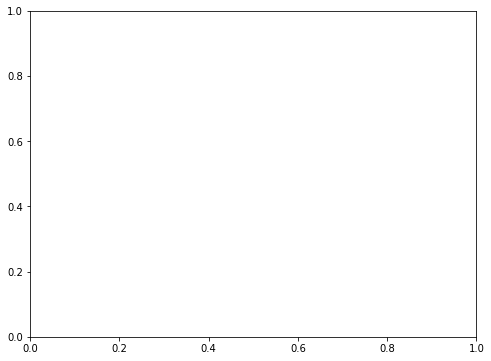

In [10]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(data=train_data, x='ndvi_ne', y='total_cases', hue='year')

In [11]:
def pre_process_train_test_data(train, test, label_var, exclude_scaling):
    labels = np.ravel(train[label_var])
    train = pd.get_dummies(train.drop(label_var, axis=1))
    test = pd.get_dummies(test)

    # match test set and training set columns
    to_drop = np.setdiff1d(test.columns, train.columns)
    to_add = np.setdiff1d(train.columns, test.columns)

    test.drop(to_drop, axis=1, inplace=True)
    test = test.assign(**{c: 0 for c in to_add})

    train.fillna(0, inplace=True)
    test.fillna(0, inplace=True)

    test_indices = test.index
    train_indices = train.index
    train_test = pd.concat([train, test])
    train_test.sort_values(['year', 'weekofyear'], inplace=True)
    train_test.interpolate(method='linear', inplace=True)

    print("Shapes before transformation")
    print("Train : ", train.shape)
    print("Test : ", test.shape)
    print("Train + Test : ", train_test.shape)

    numeric_vals = train_test.select_dtypes(include=['int64', 'float64'])
    numeric_vals = numeric_vals.loc[:, [x for x in list(numeric_vals.columns.values) if x not in exclude_scaling]]
    scaler = StandardScaler()
    train_test[numeric_vals.columns] = scaler.fit_transform(numeric_vals)

    train = train_test.loc[train_indices, :]
    test = train_test.loc[test_indices, :]

    train[label_var] = labels

    print("Shapes after transformation")
    print("Train : ", train.shape)
    print("Test : ",  test.shape)

    return train, test


print("Preprocessing Training")
label_var = 'total_cases'
exclude_scaling = ['year', 'weekofyear']
a_train, a_test = pre_process_train_test_data(train_data, X_test, label_var, exclude_scaling)
X_train = a_train.drop(label_var, axis=1)
y_train = np.ravel(a_train[label_var])

Preprocessing Training
Shapes before transformation
Train :  (1456, 24)
Test :  (416, 24)
Train + Test :  (1872, 24)
Shapes after transformation
Train :  (1456, 25)
Test :  (416, 24)


In [ ]:
X_train.columns.values

In [12]:
## restructure train data
all_train_data = {'features': X_train,
                  'labels': y_train}

## restructure test data
all_test_data = {'features': X_test}

### Cross-validation -- Tune Parameters

In [14]:
tune_params = 1
if tune_params > 0:
    bestParams = []
    cv = StratifiedShuffleSplit(n_splits=5, test_size=0.5, random_state=42)
    X = all_train_data['features'].values.astype(np.float32)
    y = all_train_data['labels'].astype(np.int16)
    pipeline_optimizer = TPOTClassifier(scoring='neg_log_loss', cv=cv, 
                                        periodic_checkpoint_folder='../data/tpot_best_models/',
                                        n_jobs=1, random_state=42, verbosity=3, memory='auto',
                                        generations=30, max_eval_time_mins=10)
    pipeline_optimizer.fit(X, y)
    pipeline_optimizer.export('tpot_best_model_pipeline.py')

29 operators have been imported by TPOT.


RuntimeError: A pipeline has not yet been optimized. Please call fit() first.

### Training Phase

In [ ]:
# trained_models = {}

# ## Train Model A
# from sklearn.ensemble import GradientBoostingClassifier
# trained_models['A'] = GradientBoostingClassifier(learning_rate=0.1, max_depth=7, 
#                                                  max_features=0.5, min_samples_leaf=14, 
#                                                  min_samples_split=20, n_estimators=100, subsample=0.6)
# trained_models['A'].fit(all_train_data['A']['features'], all_train_data['A']['labels'])

# ## Train Model B
# from sklearn.preprocessing import FunctionTransformer
# from sklearn.pipeline import make_pipeline, make_union
# from sklearn.linear_model import LogisticRegression
# from copy import copy

# trained_models['B'] = make_pipeline(make_union(FunctionTransformer(copy), 
#                                                FunctionTransformer(copy)),
#                                     LogisticRegression(C=0.01, dual=True, penalty="l2"))

# trained_models['B'].fit(all_train_data['B']['features'], all_train_data['B']['labels'])

# ## Train Model C
# from sklearn.naive_bayes import BernoulliNB
# from sklearn.ensemble import RandomForestClassifier
# from tpot.builtins import StackingEstimator

# trained_models['C'] = make_pipeline(
#     make_union(FunctionTransformer(copy), 
#                StackingEstimator(estimator=BernoulliNB(alpha=1.0, fit_prior=False))),
#     RandomForestClassifier(bootstrap=True, criterion="entropy", 
#                            max_features=0.8, min_samples_leaf=6, 
#                            min_samples_split=19, n_estimators=100))

# trained_models['C'].fit(all_train_data['C']['features'], all_train_data['C']['labels'])

### Testing Phase

In [ ]:
# # ## Predict
# predictions = {}
# for grp in all_train_data:
#     predictions[grp] = trained_models[grp].predict_proba(all_test_data[grp]['features'])

### Validate and Submit

In [ ]:
# # convert preds to data frames
# predictionsDF = {}
# for grp in all_train_data:
#     predictionsDF[grp] = make_country_sub(predictions[grp], all_test_data[grp]['features'], grp)

# submission = []
# submission = pd.concat([predictionsDF['A'], predictionsDF['B'], predictionsDF['C']])

# ## Submission Format
# submission.to_csv('../data/my_submission.csv')

# # no parameters unless we have a read_csv kwargs file
# v = DrivenDataValidator()

# if v.is_valid('../data/submission_format.csv', '../data/my_submission.csv'):
#     print "I am awesome."
# else:
#     print "I am not so cool."
